In [59]:
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt

### Define global variables

In [212]:
N = len(pd.read_csv('./nasdaq_data/nasdaq2019.csv').T)-2  # number of stocks in the index
m = 5
m_all = [5]
for i in range(N//10):  # number of stocks we pick for portfolio,[5,10,20...]  
    m_all.append(10*(i+1))
if N%10 !=0:
    m_all.append(N)

In [213]:
N

86

### Step 1: Calculate the returns of the stocks in the 2019 file

In [214]:
df_2019 = pd.read_csv('./nasdaq_data/nasdaq2019.csv')
df_2019.drop(columns=["Unnamed: 0", "Date"], inplace=True)
df_2019.head()

,ADBE,AMD,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,NDX
0,224.570007,18.830000,202.119995,52.734001,52.292500,76.956497,164.698135,78.138237,143.009995,37.893333,...,27.590000,247.970001,147.759995,105.173424,164.080002,54.252949,159.740005,36.312469,41.850056,6360.87
1,215.699997,17.049999,184.779999,51.273499,50.803001,75.014000,162.192032,73.418312,137.639999,34.118874,...,26.959999,243.360001,142.589996,101.959679,163.729996,53.686825,154.020004,33.835327,41.685154,6147.13
2,226.190002,19.000000,186.710007,53.903500,53.535500,78.769501,167.736343,75.200790,143.660004,35.575394,...,28.549999,255.029999,148.970001,106.460884,172.699997,55.472923,163.350006,35.268459,42.093060,6422.67
3,229.259995,20.570000,189.919998,53.796001,53.419498,81.475502,169.993530,75.673698,147.320007,35.496208,...,29.180000,271.000000,151.399994,106.567360,175.850006,55.791870,163.500000,36.521267,41.910801,6488.25
4,232.679993,20.750000,192.949997,54.268501,53.813999,82.829002,172.173477,77.519852,148.050003,36.172867,...,29.480000,276.000000,156.919998,107.516007,178.190002,56.908195,166.949997,36.170109,42.396816,6551.85


In [223]:
# compute daily returns using pandas pct_change()
daily_return_2019 = df_2019.pct_change()  # daily_return_2019 = (df_2019-df_2019.shift(1))/df_2019.shift(1)
# skip first row with NA 
daily_return_2019 = daily_return_2019[1:]
daily_return_2019.head()

,ADBE,AMD,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,NDX
1,-0.039498,-0.094530,-0.085791,-0.027696,-0.028484,-0.025241,-0.015216,-0.060405,-0.037550,-0.099607,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.033602
2,0.048632,0.114370,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,0.043737,0.042690,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009785,0.044824
3,0.013573,0.082632,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006289,0.025477,-0.002226,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005750,0.000918,0.035522,-0.004330,0.010211
4,0.014918,0.008751,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,0.004955,0.019063,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011596,0.009802
5,0.011819,-0.026988,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,0.017494,0.016982,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.007454


### Step 2: Calculate the correlation matrix P for 100 stocks

In [224]:
df = daily_return_2019.drop('NDX',axis=1)
df = daily_return_2019
p = df.corr()#round(decimals=4)
p.head()

,ADBE,AMD,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,NDX
ADBE,1.000000,0.452881,0.363523,0.552011,0.540343,0.598177,0.292067,0.473702,0.734279,0.506225,...,0.359382,0.201299,0.711323,0.540755,0.402075,0.228138,0.650470,0.361686,0.207533,0.743811
AMD,0.452881,1.000000,0.344298,0.418812,0.417234,0.549282,0.151507,0.503677,0.491706,0.495611,...,0.332089,0.210691,0.498350,0.330548,0.272941,0.281968,0.407660,0.438867,0.017367,0.636824
ALGN,0.363523,0.344298,1.000000,0.248549,0.250207,0.399141,0.264760,0.328049,0.370880,0.357914,...,0.174604,0.128869,0.360863,0.252778,0.334765,0.219632,0.309097,0.284910,0.088341,0.439835
GOOGL,0.552011,0.418812,0.248549,1.000000,0.997356,0.619077,0.258194,0.404616,0.482396,0.557653,...,0.353873,0.171639,0.513858,0.379253,0.276469,0.232872,0.379415,0.328285,0.059848,0.756473
GOOG,0.540343,0.417234,0.250207,0.997356,1.000000,0.609676,0.254664,0.400867,0.476778,0.558341,...,0.345534,0.172909,0.500787,0.375191,0.271037,0.230594,0.371789,0.321898,0.052541,0.750154


### Step 3: Calculate the returns of the stocks in the 2020 file

In [225]:
df_2020 = pd.read_csv('./nasdaq_data/nasdaq2020.csv')
df_2020.set_index(['Date'],inplace=True)
df_2020.drop(columns=["Unnamed: 0"], inplace=True)

# compute daily returns using pandas pct_change()
daily_return_2020 = df_2020.pct_change()  # daily_return_2020 = (df_20120-df_2020.shift(1))/df_2020.shift(1)
# skip first row with NA 
daily_return_2020 = daily_return_2020[1:]
daily_return_2020.head()



,ADBE,AMD,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,NDX
Date,,,,,,,,,,,,,,,,,,,,,
1/3/20,-0.007834,-0.010183,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,-0.017604,-0.010093,-0.009722,...,-0.021369,-0.017207,0.021095,0.009727,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.008828
1/6/20,0.005726,-0.004321,0.019398,0.026654,0.024657,0.014886,0.007674,-0.011749,-0.009262,0.007968,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,0.006211
1/7/20,-0.000959,-0.002893,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,0.022751,0.008170,-0.004703,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005034,0.020414,0.067698,-0.002077,-0.000234
1/8/20,0.013438,-0.008705,0.010386,0.007118,0.007880,-0.007809,0.000756,0.009032,0.004130,0.016087,...,-0.012323,0.019400,0.004626,0.009208,0.032620,-0.058357,0.033304,0.014484,-0.000961,0.007452
1/9/20,0.007636,0.023834,0.036853,0.010498,0.011044,0.004799,0.002980,0.000000,0.014356,0.021241,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002243,0.008669


### Step 4: Find the best 5 stocks to include in portfolio, m = 5, 10, 20, …, 90, 100

In [226]:
obj = [] #Xij=N**2, Yij=N
for i in range(N):
    for j in range(N):
        obj.append(p.iloc[i,j])
obj = np.array(obj+[0]*N)

A = np.zeros((N+N**2+1,N**2+N)) #Xij=N, Xij<Yij=N, Yij=M
b = np.zeros(N+N**2+1)
direction = np.array(['']*(N+N**2+1))

ind_vec = np.array(range(N))
row = 0
for j in range(N):
    A[row,j*N + ind_vec] = 1
    b[row] = 1
    direction[row] = '='
    row+=1
    
for i in range(N):
    for k in ind_vec*N +i:
        A[row, k] = 1
        A[row, -N+i] = -1
        b[row] = 0
        direction[row] = '<'
        row+=1

A[-1,-N:] = 1
direction[row] = '='

stock_idx_all = []

for m in m_all:
    b[row] = m
    
    portMod = gp.Model()
    portMod_x = portMod.addMVar(N**2+N,vtype=['B']*(N**2+N)) 
    portMod_con = portMod.addMConstr(A, portMod_x, direction, b)
    portMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    portMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    portMod.optimize()
    
    stock_idx = []
    for i in range(N):
        if portMod_x.x[-N:][i] == 1:
            stock_idx.append(i)
    stock_idx_all.append(stock_idx)
    print('For m = '+str(m)+', stock indexes are:', stock_idx)

For m = 5, stock indexes are: [45, 50, 80, 84, 85]
For m = 10, stock indexes are: [17, 29, 30, 46, 50, 59, 77, 80, 84, 85]
For m = 20, stock indexes are: [10, 15, 20, 29, 30, 32, 33, 34, 45, 47, 50, 53, 54, 59, 60, 72, 74, 77, 80, 85]
For m = 30, stock indexes are: [2, 6, 10, 13, 15, 20, 21, 26, 29, 30, 34, 36, 45, 47, 49, 50, 53, 54, 59, 60, 63, 66, 72, 73, 74, 77, 80, 81, 84, 85]
For m = 40, stock indexes are: [2, 4, 6, 10, 13, 15, 20, 21, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 38, 39, 45, 47, 49, 50, 54, 59, 60, 62, 63, 66, 67, 70, 72, 73, 74, 77, 80, 81, 84, 85]
For m = 50, stock indexes are: [2, 4, 6, 10, 13, 14, 15, 16, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 46, 47, 49, 50, 54, 55, 56, 59, 60, 62, 63, 64, 66, 67, 69, 70, 72, 73, 74, 76, 77, 81, 82, 84, 85]
For m = 60, stock indexes are: [1, 2, 3, 6, 10, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 46, 47, 49, 50, 53, 54, 55, 56, 59, 60, 62, 6

### Step 5: Get the weights of those stocks with m = 5, 10, 20, …, 90, 100, using the 2019 data

In [227]:
weightMod_x_all = []
objVal_all = []

for stock_idx in stock_idx_all:
    NDX_return_2019 = daily_return_2019['NDX']
    
    stocks_return_2019 = daily_return_2019.iloc[:,[i - 1 for i in stock_idx]] #changed i from i+1
    
    num1 = len(stocks_return_2019)  #250
    num2 = len(stock_idx) #5
    obj = np.array([1]*num1+[0]*num2) #yi=250, wi=5
    
    A = np.zeros((num1*2+1,num1+num2)) 
    b = []
    direction = np.array(['>']*(num1*2)+['='])
    
    row = 0
    col = 0
    for i in range(num1*2):
        if row % 2 == 0:
            A[row,col] = 1
            A[row,-len(stock_idx):] = stocks_return_2019.iloc[col].tolist()
            b.append(NDX_return_2019.iloc[col])
            row+=1
        else:
            A[row,col] = 1
            A[row,-len(stock_idx):] = [i*(-1) for i in stocks_return_2019.iloc[col].tolist()]
            b.append((NDX_return_2019.iloc[col])*(-1))
            row+=1
            col+=1
    A[row,-len(stock_idx):] = [1]*len(stock_idx)
    b.append(1)
    
    weightMod = gp.Model()
    weightMod_x = weightMod.addMVar(num1+num2) 
    weightMod_con = weightMod.addMConstr(A, weightMod_x, direction, b)
    weightMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    weightMod.Params.OutputFlag = 0
    weightMod.optimize()
    
    weightMod_x_all.append(weightMod_x.x[-len(stock_idx):])
    objVal_all.append(weightMod.objVal)
    #print(weightMod_x.x[-len(stock_idx):])

print(objVal_all)

[1.324676766768648, 1.0557951348422672, 0.5133887662018963, 0.34941182798280196, 0.2796113991229646, 0.2633328222311762, 0.241153210159826, 0.1354703595206928, 0.0, 0.0]


### Step 6: Evaluate portfolio using data from all the years from 2013 to 2022


In [228]:
eval_2020 = []


for i in range(len(m_all)):
    
    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]
    
    NDX_return_2020 = daily_return_2020['NDX'].tolist()
    stocks_return_2020 = daily_return_2020.iloc[:,[i - 1 for i in stock_idx]] #changed to i - 1 from i+1
    
    A = stocks_return_2020.to_numpy()
    B = weightMod_x
    portfolio_return_2020 = pd.DataFrame(A*B).T.sum().tolist()
    
    sum = 0
    for j in range(len(portfolio_return_2020)):
        if NDX_return_2020[j] - portfolio_return_2020[j] > 0:
            sum += NDX_return_2020[j] - portfolio_return_2020[j]
        else:
            sum += portfolio_return_2020[j] - NDX_return_2020[j]
    eval_2020.append(sum)

print(eval_2020)  #difference in return between portfolio and the index

[2.0887797693242534, 2.222757760545753, 0.8530895508058789, 0.603483421706612, 0.7208717032240358, 0.6885615231962348, 0.5611042307165797, 0.4928548596192868, 0.0, 0.0]


In [229]:
# Initialize a data frame to record evaluation results
df1 = pd.DataFrame(columns = ['num_of_m', 'evaluation_by_2020'])
df1['num_of_m'] = m_all
df1['evaluation_by_2020'] = eval_2020
df1

,num_of_m,evaluation_by_2020
0,5,2.088780
1,10,2.222758
2,20,0.853090
3,30,0.603483
4,40,0.720872
5,50,0.688562
6,60,0.561104
7,70,0.492855
8,80,0.000000
9,86,0.000000


### Step 7: Evaluate portfolio using 2019 data


In [230]:
eval_2019 = []

for i in range(len(m_all)):
    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]
    
    NDX_return_2019 = daily_return_2019['NDX'].tolist()
    stocks_return_2019 = daily_return_2019.iloc[:,[i - 1 for i in stock_idx]] #same thing
    
    A = stocks_return_2019.to_numpy()
    B = weightMod_x
    portfolio_return_2019 = pd.DataFrame(A*B).T.sum().tolist()
    
    sum = 0
    for j in range(len(portfolio_return_2019)):
        if NDX_return_2019[j] - portfolio_return_2019[j] > 0:
            sum += NDX_return_2019[j] - portfolio_return_2019[j]
        else:
            sum += portfolio_return_2019[j] - NDX_return_2019[j]
    eval_2019.append(sum)

print(eval_2019)  #difference in return between portfolio and the index

[1.3246767667686479, 1.0557951348422672, 0.5133887662018961, 0.349411827982802, 0.2796113991229647, 0.26333282223117643, 0.2411532101598261, 0.13547094893050848, 0.0, 0.0]


### Evaluate Using 2013-2022 data


In [234]:
eval_2013 = []

for i in range(len(m_all)):
    df_2013 = pd.read_csv('./nasdaq_data/nasdaq2013.csv')
    df_2013.set_index(['Date'],inplace=True)
    df_2013.drop(columns=["Unnamed: 0"], inplace=True)

    # compute daily returns using pandas pct_change()
    daily_return_2013 = df_2013.pct_change()  
    # skip first row with NA 
    daily_return_2013 = daily_return_2013[1:]
    daily_return_2013.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]
    
    NDX_return_2013 = daily_return_2013['NDX'].tolist()
    stocks_return_2013 = daily_return_2013.iloc[:,[i - 1 for i in stock_idx]] #same thing
    
    A = stocks_return_2013.to_numpy()
    B = weightMod_x
    portfolio_return_2013 = pd.DataFrame(A*B).T.sum().tolist()
    
    sum = 0
    for j in range(len(portfolio_return_2013)):
        if NDX_return_2013[j] - portfolio_return_2013[j] > 0:
            sum += NDX_return_2013[j] - portfolio_return_2013[j]
        else:
            sum += portfolio_return_2013[j] - NDX_return_2013[j]
    eval_2013.append(sum)

print(eval_2013)  #difference in return between portfolio and the index

[2.300216350389876, 2.3243968985475574, 2.2301903245082624, 2.203434264705055, 2.153353829336013, 2.0929140215654343, 2.115178167162846, 2.083203349885282, 0.0, 0.0]


In [235]:
eval_2014 = []

for i in range(len(m_all)):
    df_2014 = pd.read_csv('./nasdaq_data/nasdaq2014.csv')
    df_2014.set_index(['Date'], inplace=True)
    df_2014.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2014 = df_2014.pct_change()
    # Skip the first row with NA
    daily_return_2014 = daily_return_2014[1:]
    daily_return_2014.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2014 = daily_return_2014['NDX'].tolist()
    stocks_return_2014 = daily_return_2014.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2014.to_numpy()
    B = weightMod_x
    portfolio_return_2014 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2014)):
        if NDX_return_2014[j] - portfolio_return_2014[j] > 0:
            sum_diff += NDX_return_2014[j] - portfolio_return_2014[j]
        else:
            sum_diff += portfolio_return_2014[j] - NDX_return_2014[j]
    eval_2014.append(sum_diff)

print(eval_2014)  # Difference in return between portfolio and the index

[2.4288207484165727, 2.434322754026484, 2.3102163784941574, 2.446276164362183, 2.497700151117434, 2.477696252398915, 2.4032124757992355, 2.4097004591223024, 0.0, 0.0]


In [236]:
eval_2015 = []

for i in range(len(m_all)):
    df_2015 = pd.read_csv('./nasdaq_data/nasdaq2015.csv')
    df_2015.set_index(['Date'], inplace=True)
    df_2015.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2015 = df_2015.pct_change()
    # Skip the first row with NA
    daily_return_2015 = daily_return_2015[1:]
    daily_return_2015.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2015 = daily_return_2015['NDX'].tolist()
    stocks_return_2015 = daily_return_2015.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2015.to_numpy()
    B = weightMod_x
    portfolio_return_2015 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2015)):
        if NDX_return_2015[j] - portfolio_return_2015[j] > 0:
            sum_diff += NDX_return_2015[j] - portfolio_return_2015[j]
        else:
            sum_diff += portfolio_return_2015[j] - NDX_return_2015[j]
    eval_2015.append(sum_diff)

print(eval_2015)  # Difference in return between portfolio and the index


[2.8871327854406243, 2.9275398229458944, 3.0861579434084647, 3.0288846285060793, 2.9654206126947806, 2.955032756163823, 2.9486535930330176, 2.9668165788850764, 0.0, 0.0]


In [237]:
eval_2016 = []

for i in range(len(m_all)):
    df_2016 = pd.read_csv('./nasdaq_data/nasdaq2016.csv')
    df_2016.set_index(['Date'], inplace=True)
    df_2016.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2016 = df_2016.pct_change()
    # Skip the first row with NA
    daily_return_2016 = daily_return_2016[1:]
    daily_return_2016.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2016 = daily_return_2016['NDX'].tolist()
    stocks_return_2016 = daily_return_2016.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2016.to_numpy()
    B = weightMod_x
    portfolio_return_2016 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2016)):
        if NDX_return_2016[j] - portfolio_return_2016[j] > 0:
            sum_diff += NDX_return_2016[j] - portfolio_return_2016[j]
        else:
            sum_diff += portfolio_return_2016[j] - NDX_return_2016[j]
    eval_2016.append(sum_diff)

print(eval_2016)  # Difference in return between portfolio and the index


[1.241981511660815, 1.1458982067648753, 0.6424549798969076, 0.46640735646223874, 0.3934868597422793, 0.3687620736359391, 0.36394465289092204, 0.2607036900930519, 0.0, 0.0]


In [238]:
eval_2017 = []

for i in range(len(m_all)):
    df_2017 = pd.read_csv('./nasdaq_data/nasdaq2017.csv')
    df_2017.set_index(['Date'], inplace=True)
    df_2017.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2017 = df_2017.pct_change()
    # Skip the first row with NA
    daily_return_2017 = daily_return_2017[1:]
    daily_return_2017.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2017 = daily_return_2017['NDX'].tolist()
    stocks_return_2017 = daily_return_2017.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2017.to_numpy()
    B = weightMod_x
    portfolio_return_2017 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2017)):
        if NDX_return_2017[j] - portfolio_return_2017[j] > 0:
            sum_diff += NDX_return_2017[j] - portfolio_return_2017[j]
        else:
            sum_diff += portfolio_return_2017[j] - NDX_return_2017[j]
    eval_2017.append(sum_diff)

print(eval_2017)  # Difference in return between portfolio and the index


[1.001352255755614, 0.9815736424190076, 0.5217679944787259, 0.3977631890210843, 0.35158219918836586, 0.3127554467967125, 0.3053346970629962, 0.21193141614602118, 0.0, 0.0]


In [239]:
eval_2018 = []

for i in range(len(m_all)):
    df_2018 = pd.read_csv('./nasdaq_data/nasdaq2018.csv')
    df_2018.set_index(['Date'], inplace=True)
    df_2018.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2018 = df_2018.pct_change()
    # Skip the first row with NA
    daily_return_2018 = daily_return_2018[1:]
    daily_return_2018.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2018 = daily_return_2018['NDX'].tolist()
    stocks_return_2018 = daily_return_2018.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2018.to_numpy()
    B = weightMod_x
    portfolio_return_2018 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2018)):
        if NDX_return_2018[j] - portfolio_return_2018[j] > 0:
            sum_diff += NDX_return_2018[j] - portfolio_return_2018[j]
        else:
            sum_diff += portfolio_return_2018[j] - NDX_return_2018[j]
    eval_2018.append(sum_diff)

print(eval_2018)  # Difference in return between portfolio and the index


[1.4290987783761726, 1.3871469460347996, 0.7093005643761878, 0.49260326344990424, 0.4305665017288469, 0.40146104595982973, 0.42277022089120103, 0.25828106799218775, 0.0, 0.0]


In [240]:
eval_2021 = []

for i in range(len(m_all)):
    df_2021 = pd.read_csv('./nasdaq_data/nasdaq2021.csv')
    df_2021.set_index(['Date'], inplace=True)
    df_2021.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2021 = df_2021.pct_change()
    # Skip the first row with NA
    daily_return_2021 = daily_return_2021[1:]
    daily_return_2021.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2021 = daily_return_2021['NDX'].tolist()
    stocks_return_2021 = daily_return_2021.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2021.to_numpy()
    B = weightMod_x
    portfolio_return_2021 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2021)):
        if NDX_return_2021[j] - portfolio_return_2021[j] > 0:
            sum_diff += NDX_return_2021[j] - portfolio_return_2021[j]
        else:
            sum_diff += portfolio_return_2021[j] - NDX_return_2021[j]
    eval_2021.append(sum_diff)

print(eval_2021)  # Difference in return between portfolio and the index


[1.4459140011658573, 1.64142471856779, 0.7751773739304622, 0.6795651195441539, 0.6280713286653291, 0.6552240800040227, 0.6099230072445055, 0.5511281650213264, 0.0, 0.0]


In [241]:
eval_2022 = []

for i in range(len(m_all)):
    df_2022 = pd.read_csv('./nasdaq_data/nasdaq2022.csv')
    df_2022.set_index(['Date'], inplace=True)
    df_2022.drop(columns=["Unnamed: 0"], inplace=True)

    # Compute daily returns using pandas pct_change()
    daily_return_2022 = df_2022.pct_change()
    # Skip the first row with NA
    daily_return_2022 = daily_return_2022[1:]
    daily_return_2022.head()

    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]

    NDX_return_2022 = daily_return_2022['NDX'].tolist()
    stocks_return_2022 = daily_return_2022.iloc[:, [i - 1 for i in stock_idx]]  # Same thing

    A = stocks_return_2022.to_numpy()
    B = weightMod_x
    portfolio_return_2022 = pd.DataFrame(A * B).T.sum().tolist()

    sum_diff = 0
    for j in range(len(portfolio_return_2022)):
        if NDX_return_2022[j] - portfolio_return_2022[j] > 0:
            sum_diff += NDX_return_2022[j] - portfolio_return_2022[j]
        else:
            sum_diff += portfolio_return_2022[j] - NDX_return_2022[j]
    eval_2022.append(sum_diff)

print(eval_2022)  # Difference in return between portfolio and the index


[1.6897460548166312, 1.8609769370008657, 1.0242033298181887, 0.8150571178119759, 0.7129462932153549, 0.7958086983801246, 0.7524483482984077, 0.6037599422686755, 0.0, 0.0]


In [242]:
df1['evaluation_by_2013'] = eval_2013
df1['evaluation_by_2014'] = eval_2014   
df1['evaluation_by_2015'] = eval_2015
df1['evaluation_by_2016'] = eval_2016
df1['evaluation_by_2017'] = eval_2017
df1['evaluation_by_2018'] = eval_2018
df1['evaluation_by_2019'] = eval_2019  # we can use Model.objVal directly
df1['evaluation_by_2021'] = eval_2021
df1['evaluation_by_2022'] = eval_2022

df1

,evaluation_by_2020,evaluation_by_2019,evaluation_by_2013,evaluation_by_2014,evaluation_by_2015,evaluation_by_2016,evaluation_by_2017,evaluation_by_2018,evaluation_by_2021,evaluation_by_2022
num_of_m,,,,,,,,,,
5,2.088780,1.324677,2.300216,2.428821,2.887133,1.241982,1.001352,1.429099,1.445914,1.689746
10,2.222758,1.055795,2.324397,2.434323,2.927540,1.145898,0.981574,1.387147,1.641425,1.860977
20,0.853090,0.513389,2.230190,2.310216,3.086158,0.642455,0.521768,0.709301,0.775177,1.024203
30,0.603483,0.349412,2.203434,2.446276,3.028885,0.466407,0.397763,0.492603,0.679565,0.815057
40,0.720872,0.279611,2.153354,2.497700,2.965421,0.393487,0.351582,0.430567,0.628071,0.712946
50,0.688562,0.263333,2.092914,2.477696,2.955033,0.368762,0.312755,0.401461,0.655224,0.795809
60,0.561104,0.241153,2.115178,2.403212,2.948654,0.363945,0.305335,0.422770,0.609923,0.752448
70,0.492855,0.135471,2.083203,2.409700,2.966817,0.260704,0.211931,0.258281,0.551128,0.603760
80,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [246]:
# df1.set_index('num_of_m',inplace=True)

(0.0, 1.2)

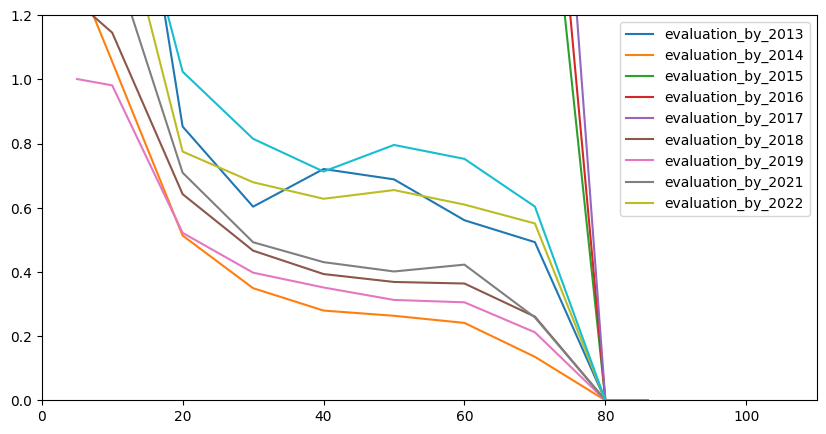

In [245]:
plt.figure(figsize=(10,5))
plt.plot(df1)
plt.legend(["evaluation_by_2013","evaluation_by_2014","evaluation_by_2015","evaluation_by_2016","evaluation_by_2017","evaluation_by_2018","evaluation_by_2019","evaluation_by_2021","evaluation_by_2022"])
plt.xlim([0, 110])
plt.ylim([0, 1.2])